In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [2]:
class SimpleTokenizer:
    def __init__(self, text_corpus):
        chars = sorted(list(set(text_corpus)))
        self.chars = ['<pad>', '<sos>', '<eos>'] + chars

        self.stoi = {ch: i for i, ch in enumerate(self.chars)}
        self.itos = {i: ch for i, ch in enumerate(self.chars)}

        self.vocab_size = len(self.chars)
        self.pad_token_id = self.stoi['<pad>']
        self.sos_token_id = self.stoi['<sos>']
        self.eos_token_id = self.stoi['<eos>']

    def encode(self, text):
        return [self.stoi[c] for c in text]
    
    def decode(self, indices):
        if isinstance(indices, torch.Tensor):
            indices = indices.tolist()
        return ''.join([self.itos[i] for i in indices if i < len(self.itos)])

In [3]:
class ToyDataset(Dataset):
    def __init__(self, text_data, tokenizer:SimpleTokenizer, max_len):
        self.data = text_data # 리스트 형태
        self.tokenizer = tokenizer # 토크나이저 위에
        self.max_len = max_len # 입력 고정 길이 (입력 통일)

    def __len__(self):
        return len(self.data) # 데이터에 몇개 있는지
    
    def __getitem__(self, idx):
        text = self.data[idx]

        encoded = self.tokenizer.encode(text)

        token_ids = [self.tokenizer.sos_token_id] + encoded + [self.tokenizer.eos_token_id]
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len] # 자르기

        pad_len = self.max_len - len(token_ids) # 남는 거
        token_ids = token_ids + [self.tokenizer.pad_token_id] * pad_len

        return torch.tensor(token_ids, dtype=torch.long)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        '''
            d_model: 임베딩 차원
            max_len: 최대길이
        '''
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0) # [max_len, d_model] -> [1, max_len, d_model]
        self.register_buffer('pe', pe)
        self.pe: torch.Tensor
        # pe 텐서를 모델의 buffer로 등록, => state_dict에 포함되어 모델에 함께 관리
        
    def forward(self, x):
        # x: [batch_size, seq_len, d_model]
        x = x + self.pe[:, :x.size(1), :]
        return x


In [5]:
corpus = ["hello transformer", "jupyter notebook is good", "i love python"]
max_len = 12
d_model = 32
batch_size = 2

# Tokenizer 생성
tokenizer = SimpleTokenizer("".join(corpus))
print(f"vocab size: {tokenizer.vocab_size}")
print(f"dict: {tokenizer.stoi}")

dataset = ToyDataset(corpus, tokenizer, max_len)
dataloader = DataLoader(dataset, batch_size, shuffle= True)

batch_indices = next(iter(dataloader))
print(f"Input batch shape: {batch_indices.shape}")
print(f"첫 번째 문장: {tokenizer.decode(batch_indices[0])}")

vocab size: 25
dict: {'<pad>': 0, '<sos>': 1, '<eos>': 2, ' ': 3, 'a': 4, 'b': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'y': 24}
Input batch shape: torch.Size([2, 12])
첫 번째 문장: <sos>jupyter not


In [6]:
embedding = nn.Embedding(tokenizer.vocab_size, d_model)
pos_encoder = PositionalEncoding(d_model, max_len)

embed_out = embedding(batch_indices)
final_out = pos_encoder(embed_out)
print(f"최종 Output shape: {final_out.shape}")
# print(embed_out)

최종 Output shape: torch.Size([2, 12, 32])


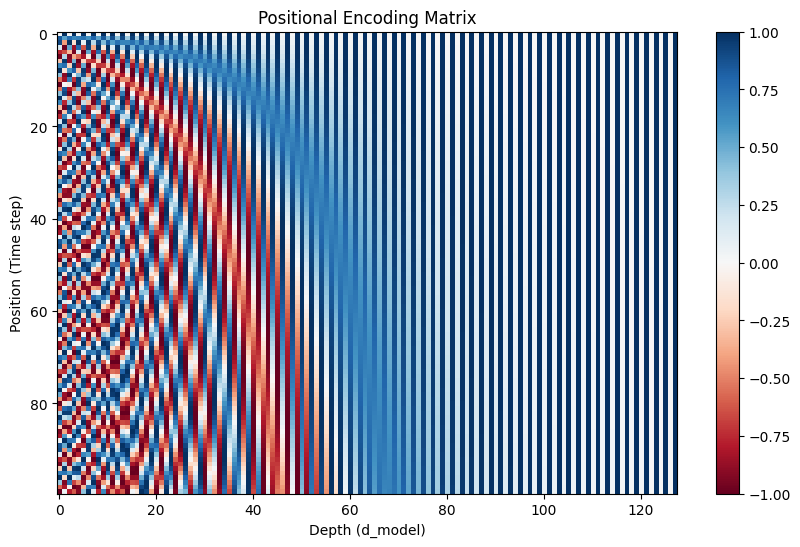

In [8]:
pe_test = PositionalEncoding(d_model=128, max_len=100)
y = pe_test.pe.squeeze(0).numpy()

plt.figure(figsize=(10, 6))
plt.imshow(y, cmap='RdBu', aspect='auto')
plt.title("Positional Encoding Matrix")
plt.xlabel("Depth (d_model)")
plt.ylabel("Position (Time step)")
plt.colorbar()
plt.show()

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1) 
        # 마지막 축이 합 1되게 정규화
    
    def forward(self, q, k, v, mask=None):
        # q,k,v: [batch_size, n_heads, seq_len, head_dim]
        # qk^T : [batch_size, n_heads, seq_len, seq_len]

        scores = torch.matmul(q, k.transpose(-1, -2))
        # 마지막 두 차원만 곱함

        d_k = q.size(-1)
        scores = scores/math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)

        attn_weights = self.softmax(scores)

        output = torch.matmul(attn_weights, v)
        return output, attn_weights


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        # d_model: 모델 차원, n_heads: head 수
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        
        # 각 헤드 차원
        self.head_dim = d_model // n_heads

        assert d_model % n_heads == 0, "d_model가 n_heads의 배수 아님"

        # 파라미터화 행렬
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        
        self.w_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention()
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        # 선형 변환 및 헤드 분리
        # [batch, seq_len, d_model] -> [batch, seq_len, n_heads, head_dim]
        # -> [batch, n_heads, seq_len, head_dim] (transpose)

        Q = self.w_q(q).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = self.w_k(k).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.w_v(v).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Scaled dot product Attention
        # output shape: [batch, n_heads, seq_len, head_dim]
        output, attn_weights = self.attention(Q, K, V, mask=mask)
        output: torch.Tensor
        # Concat
        # 최종: [batch, seq_len, d_model]
        
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        output = self.w_o(output)
        return output, attn_weights




In [12]:
# 어텐션 테스트

d_model = 32
n_heads = 4
seq_len = 12
batch_size = 2

mha = MultiHeadAttention(d_model, n_heads)

# 가짜 position encoded embedded 데이터
x = torch.randn(batch_size, seq_len, d_model)

output, weights = mha(x, x, x, mask=None)

print(f"input shape: {x.shape}")
print(f"output shape: {output.shape}")

print (f"attn weights: {weights.shape}")
# [2, 4, 12, 12]

if x.shape == output.shape:
    print("차원 일치")
else:
    print("차원 불일치")

AttributeError: 'Tensor' object has no attribute 'transopose'